In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Display the BaseAgent class documentation
#help(BaseAgent)

## Amiral

### TOOLS

In [2]:
### DISCRETIZATION OF POSITION TO LOCATION ON MAP 
def position_to_loc(x, y, grid_size=32):
    loc = 0
    if y < grid_size * (1/2) and x < grid_size * (1/4):
        loc = 1
    if y < grid_size * (1/2) and x >= grid_size * (1/4):
        loc = 4
    if y < grid_size * (1/2) and x < grid_size * (1/2) and x >= grid_size * (1/4):
        loc = 3
    if y < grid_size * (1/2) and x >= grid_size * (1/2) and x < grid_size * (3/4):
        loc = 2

    if y >= grid_size * (1/2) and x < grid_size * (1/4):
        loc = 5
    if y >= grid_size * (1/2) and x >= grid_size * (1/4):
        loc = 6
    if y >= grid_size * (1/2) and y < grid_size * (3/4):
        if x >= grid_size * (1/4) and x < grid_size * (3/8):
            loc = 7
        if x >= grid_size * (3/8) and x < grid_size * (4/8):
            loc = 9
        if x >= grid_size * (4/8) and x < grid_size * (5/8):
            loc = 8
        if x >= grid_size * (5/8) and x < grid_size * (6/8):
            loc = 10

    if y >= grid_size * (3/4) and y < grid_size - 2:
        if x >= grid_size * (1/4) and x < grid_size * (3/8):
            loc = 11
        if x >= grid_size * (3/8) and x < grid_size * (4/8):
            loc = 13
        if x >= grid_size * (4/8) and x < grid_size * (5/8):
            loc = 12
        if x >= grid_size * (5/8) and x < grid_size * (6/8):
            loc = 14
    
    if y >= grid_size - 2:
        if x < grid_size * (3/8):
            loc = 15
        if x >= grid_size * (3/8) and x < grid_size * (4/8):
            loc = 17
        if x >= grid_size * (4/8) and x < grid_size * (5/8):
            loc = 16
        if x >= grid_size * (5/8):
            loc = 18
    return loc

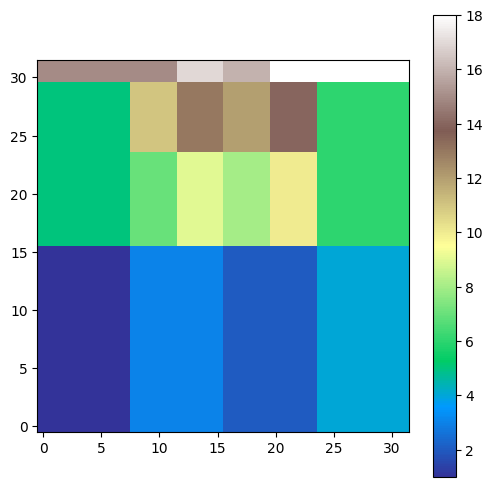

In [3]:
matrice = np.zeros((32,32))

for x in range(32):
    for y in range(32):
        matrice[y][x] = position_to_loc(x, y)
        
plt.figure(figsize=(6, 6))
plt.imshow(matrice, cmap='terrain')
plt.colorbar()
plt.gca().invert_yaxis()  # Inversion de l'axe Y
plt.show()


In [4]:
def actions_to_dir(i:int):
    if i < 0 or i >= 8:
        u = (0,0)
        return u
    if i == 0:
        u = (0,1)
    if i == 1:
        u = (1,1)
    if i == 2:
        u = (1,0)
    if i == 3:
        u = (1,-1)
    if i == 4:
        u = (0,-1)
    if i == 5:
        u = (-1,-1)
    if i == 6:
        u = (-1,0)
    if i == 7:
        u = (-1,1)

    ux, uy = u
    n_u = np.sqrt(ux**2 + uy**2)
    return u / n_u    

def dir_to_goal(x,y,x_g=16.,y_g=31.):
    ux = x_g - x
    uy = y_g - y
    n_u = np.sqrt(ux**2 + uy**2)
    if n_u > 0:
        ux = ux / n_u
        uy = uy / n_u
        return (ux, uy)
    else:
        return (0,0)

def rosace_des_vents(x,y,x_g=16.,y_g=31.):
    directions = np.zeros(9)
    dir_g = dir_to_goal(x,y,x_g=x_g ,y_g=y_g)

    for action in range(0,9):
        u = actions_to_dir(action)
        dot = np.dot(u, dir_g)
        directions[action] = dot
    return directions

def get_ahead(x_bin, y_bin, factor):
    factor = max(factor, 1)
    left = (x_bin, y_bin) + factor * actions_to_dir(6)
    up = (x_bin, y_bin) + factor * actions_to_dir(0)
    right = (x_bin, y_bin) + factor * actions_to_dir(2)
    upleft = (x_bin, y_bin) + factor * actions_to_dir(7)
    upright = (x_bin, y_bin) + factor * actions_to_dir(1) 

    locations = []
    positions = []

    for direction in [left, up, right, upleft, upright]:
        x, y = direction
        x = min(max(0, x),31)
        y = min(max(0,y), 31)
        x, y = int(round(x)), int(round(y))
        positions.append((x,y))

        i = 6 + (32 * 2 * y) + (2 * x)
        j = 6 + (32 * 2 * y) + (2 * x) + 1
        locations.append((i,j))
    return locations, positions 

def get_diff_angle(goal: tuple, wind: tuple):
    x, y = goal
    wx, wy = wind

    goal_angle = np.arctan2(y, x)
    wind_angle = np.arctan2(wy, wx)

    relative_wind_direction = goal_angle - wind_angle
    relative_wind_direction = (relative_wind_direction + np.pi) % (2 * np.pi) - np.pi
    return ((180/np.pi)*relative_wind_direction+180)

def opposite_actions(i: int):
    if i == 8:
        return 8
    else:
        return (i + 4) % 8

In [5]:
get_ahead(x_bin=16, y_bin=0, factor=1)

([(36, 37), (102, 103), (40, 41), (100, 101), (104, 105)],
 [(15, 0), (16, 1), (17, 0), (15, 1), (17, 1)])

### TESTING TOOLS

In [49]:
def test(sailor, num_test=50, max_steps=150, seed = None, env = None, verbose = True):
    """Simple testing method during training to show improvements of results without exploration"""

    # Turn off exploration for evaluation
    exploration_rate = sailor.exploration_rate
    sailor.exploration_rate = 0

    if verbose:
        print("------ BEGINNING TEST -------------------------------                                ")
        print(f"exploration rate set to : {sailor.exploration_rate}")

    # Create test environment
    dico_env = {}
    dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
    dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
    dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

    if env is None:
        i = np.random.randint(1, 4)
    else:
        i = env
    test_env = dico_env[i]

    if verbose:
        print(f"Testing the trained agent on {num_test} new episodes...")
    # Testing loop
    results_steps = []
    results_rew = []
    results_avg_speed = []

    for episode in range(num_test):
        if verbose:
            perc = min((episode + 1)//int((num_test/20)), 20) 
            print(f"Progress: [{'#'*(perc) + '-'*(20-perc)}]",end="\r")
        if seed is None:
            a_seed = 100000+episode
        else:
            a_seed = seed[episode]

        # Reset environment
        sailor.clear_history()

        observation, info = test_env.reset(seed=a_seed)  # Different seeds from training
        
        total_reward = 0
        
        for step in range(max_steps):
            # Select action using learned policy
            action = sailor.act(observation)
            observation, reward, done, truncated, info = test_env.step(action)
        
            total_reward += reward*np.power(sailor.discount_factor, step)
            
            # Break if episode is done
            if done or truncated:
                results_steps.append(step)
                results_rew.append(total_reward)
                results_avg_speed.append(sailor.get_avg_veloc())
                break
        
        if not(done):
            results_steps.append(step)
            results_rew.append(0)
            results_avg_speed.append(-1)
    
    sailor.exploration_rate = exploration_rate
    if verbose:
        print(f"exploration rate re-set to : {sailor.exploration_rate}")
        print("------ END OF TEST ----------------------------------                                ",end="\n")
        
    return results_steps, results_rew, results_avg_speed


### CLASS

In [7]:


class MyNaiveAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.hist_pos = []
        self.hist_actions = [0]
        self.exploration_rate = 0
        self.discount_factor = 0.99
        self.hist_veloc = []

    def act(self, observation):
        x, y = observation[0], observation[1]
        self.hist_pos.append((x, y))
        vx, vy = observation[2], observation[3]
        self.hist_actions.append(0)
        self.hist_veloc.append((vx,vy))
        return 0

    def clear_history(self):
        self.hist_pos.clear()
        self.hist_actions.clear()
        self.hist_actions.append(0)
        self.hist_veloc.clear()

    def get_avg_veloc(self):
        v = []
        for vx, vy in self.hist_veloc:
            v.append(np.sqrt(vx**2 + vy**2))
        return np.mean(v)
        




In [32]:
class Capitaine(BaseAgent):
    """A TD(λ) agent with eligibility traces using a Q-table."""

    def __init__(self, learning_rate=0.07, discount_factor=0.99, exploration_rate=0.1, lambda_=0.8):
        super().__init__()
        self.np_random = np.random.default_rng()
       
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.lambda_ = lambda_

        self.position_bins = 32
        self.velocity_bins = 8
        self.wind_bins = 8
        self.goal_x = 16.
        self.goal_y = 31.
        self.wind_factor = 4
        self.ratio_exploration = .6

        self.eligibility = {}
        self.q_table = {}
        self.polar = {}
        self.q_explore = {}

        # only for history
        self.training_session = 0
        self.learning_session = 0
        self.hist_pos = []
        self.hist_veloc = []
        self.hist_actions = [0]
        self.hist_explo = []

    def discretize_state(self, observation):
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]

        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)

        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)
            v_bin = int(((-v_direction + 1/2*np.pi) / (2 * np.pi) * (self.velocity_bins - 1)) + 1) % self.velocity_bins

        wind_direction = np.arctan2(wy, wx)
        wind_bin = int(((-wind_direction + 1/2*np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        wind_mag = int(self.wind_factor*np.sqrt(wx**2 + wy**2))

        ### Adding more info to state

        wind_ahead = []

        locations, positions = get_ahead(x_bin=x_bin, y_bin=y_bin, factor=wind_mag)
        for loc in locations:
            i, j = loc
            wxx, wyy = observation[i], observation[j]
            wind_d = np.arctan2(wyy, wxx)
            wind_b = int(((-wind_direction + 1/2*np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
            wind_ahead.append(wind_b)
        
        wind_tup = tuple(wind_ahead)

        # Storing data
        self.hist_pos.append((x, y))
        self.hist_veloc.append((vx, vy))

        return ((x_bin, y_bin, wind_bin, wind_mag) + wind_tup)

    def act(self, observation):
        state = self.discretize_state(observation)

        ### CALCUL OF MEASURES ON OBSERVATIONS
        x, y = observation[0], observation[1]
        wx, wy = observation[4], observation[5]
        
        wind_direction = np.arctan2(wy, wx)

        wind_bin = int(((-wind_direction + 1/2*np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        wind_mag = int(self.wind_factor*np.sqrt(wx**2 + wy**2))

        ### CALCUL OF BEST COURSES
        v = np.zeros(9)
        directions = rosace_des_vents(x,y,x_g=self.goal_x, y_g=self.goal_y)
        for action in range(0, 9):
            self.polar.setdefault((wind_bin, wind_mag, action),[])
            if self.polar[(wind_bin, wind_mag, action)] == []:
                v[action] = 0
            else:
                v[action] = (np.mean(self.polar[(wind_bin, wind_mag, action)]))
        courses = directions * v      

        ### DECREASING EPSILON
        self.q_explore.setdefault(state, 0)
        epsilon = max(1 - (self.q_explore[state]/30), 0.2)
        self.hist_explo.append(epsilon * self.exploration_rate)

        ### Policy when not moving
        if len(self.hist_pos) > 4:
            x1, y1 = self.hist_pos[-1]
            x2, y2 = self.hist_pos[-2]
            x3, y3 = self.hist_pos[-3]
            x4, y4 = self.hist_pos[-4]

            d12 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            d23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
            d34 = np.sqrt((x3 - x4)**2 + (y3 - y4)**2)

            if d12 < .1 and d23 < .1 and d34 < .1:
                act = np.argmax(courses)
                self.hist_actions.append(act)
                return act

        rand_n = self.np_random.random()

        if rand_n < self.exploration_rate * epsilon * self.ratio_exploration:
            "Chose the best course between the courses that make us progress toward the goal"
            act = np.argmax(courses)
            self.q_explore[state] += 1


        elif rand_n < self.exploration_rate * epsilon:
            act = np.random.randint(0,8)
            self.q_explore[state] += 1

        
        else:
            if state not in self.q_table:
                self.q_table.setdefault(state, np.zeros(9))
            act = np.argmax(self.q_table[state])
                
        self.hist_actions.append(act)
        return act

    def learn(self, state, action, reward, next_state, next_action):
        self.q_table.setdefault(state, np.zeros(9))
        self.q_table.setdefault(next_state, np.zeros(9))
        self.eligibility.setdefault(state, np.zeros(9))
        self.learning_session += 1

        self.learning_rate = max(0.02, self.learning_rate - (1/1000))

        # TD error
        td_target = reward + self.discount_factor * self.q_table[next_state][next_action]
        td_error = td_target - self.q_table[state][action]

        # Update eligibility trace
        self.eligibility[state][action] += 1

        # Update all Q-values and decay traces
        for s in self.q_table:
            self.eligibility.setdefault(s, np.zeros(9))
            for a in range(9):
                self.q_table[s][a] += self.learning_rate * td_error * self.eligibility[s][a]
                self.eligibility[s][a] *= self.discount_factor * self.lambda_

    def learn_polar(self, action, observation, next_observation):
        wx, wy = observation[4], observation[5]
        wind_direction = np.arctan2(wy, wx)

        wind_bin = int(((-wind_direction + 1/2*np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        wind_mag = int(self.wind_factor*np.sqrt(wx**2 + wy**2))
        
        speed = np.sqrt(next_observation[2]**2 + next_observation[3]**2)

        self.polar.setdefault((wind_bin, wind_mag, action),[])
        self.polar[(wind_bin, wind_mag, action)].append(speed)


    def reset(self):
        """Reset eligibility traces at the end of an episode."""
        self.eligibility = {}

    def clear_history(self):
        self.hist_pos.clear()
        self.hist_veloc.clear()
        self.hist_actions.clear()
        self.hist_actions.append(0)
        self.hist_explo.clear()

    def seed(self, seed=None):
        self.np_random = np.random.default_rng(seed)

    def save(self, path):
        import pickle
        with open(path, 'wb') as f:
            pickle.dump((self.q_table, self.eligibility), f)

    def load(self, path):
        import pickle
        with open(path, 'rb') as f:
            self.q_table, self.eligibility = pickle.load(f)

    def get_avg_veloc(self):
        v = []
        for vx, vy in self.hist_veloc:
            v.append(np.sqrt(vx**2 + vy**2))
        return np.mean(v)
        

### TRAINING

In [53]:
sailor = Capitaine(
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.3,
    lambda_=0.8)

np.random.seed(42)
sailor.seed(42)

In [56]:
import time

### TRAINING PHASE
sailor.ratio_exploration = 0.95
sailor.exploration_rate = .3

##### PARAMETERS OF TRAINING #####
num_episodes = 7000
max_steps = 1000    

batch_train = 25
batch_test = 250


### Create environment with a simple initial windfield ###
dico_env = {}
dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

### BOOK KEEPING
train_hist = {
    "episode": [],
    "rewards": [],
    "steps": [],
    "success": [],
    "environnement": [],
    "exploration": []
    }

### TRAINING LOOP
print(f"Starting full training with {num_episodes} episodes...")

start_time = time.time()
phase = 0

for episode in range(num_episodes):

    # CHOSE ENVIRONEMENT FOR EPISODE
    i = np.random.randint(1, 4)
    env = dico_env[i]

    sailor.clear_history()
    sailor.reset()
    sailor.training_session += 1
    
    # INITIAL ENVIRONNEMENT
    observation, info = env.reset(seed=sailor.training_session)
    state = sailor.discretize_state(observation)
    if episode ==0:
        print(f"Length of state: {len(state)}")
    # SET REWARD TO 0
    total_reward = 0

    if (episode) % batch_train == 0 or episode == 0: 
        q_size = len(sailor.q_table)

    for step in range(max_steps):
        if (step) % 25 == 0:
            perc = min((step)//25, 200//25)
            print(f"Episode: [{episode + 1}/{num_episodes}], Training session: [{sailor.training_session}], Environnement [{i}], Steps: [{'#'*(perc)+'-'*(200//25 - perc)}], " +
            f"Q size: (+{len(sailor.q_table)-q_size}) {' '*10}", end="\r")
        # Select action and take step
        action = sailor.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = sailor.discretize_state(next_observation)

        # Select next action for TD(λ) update
        next_action = sailor.act(next_observation)

        # Update Q-table using TD(λ)
        sailor.learn(state, action, reward, next_state, next_action)
        sailor.learn_polar(action, observation, next_observation)

        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward

        # Break if episode is done
        if done or truncated:
            break

    

    ### STORING TRAINING HIST ###
    train_hist["episode"].append(episode)
    train_hist["environnement"].append(i)
    train_hist["rewards"].append(total_reward)
    train_hist["steps"].append(step + 1)
    train_hist["success"].append(done)
    train_hist["exploration"].append(sailor.hist_explo)


    if (episode + 1) % batch_train == 0:
        delta = time.time() - start_time
        avg_steps = np.mean(train_hist["steps"][-batch_train:])
        avg_rew = np.mean(train_hist["rewards"][-batch_train:])
        envir = train_hist["environnement"][-batch_train:]
        avg_explo = np.mean(train_hist["exploration"][-batch_train:][:])

        print(
            f"Episode: [{episode + 1}/{num_episodes}], Average Steps: {avg_steps:.1f}, "+
            f"Average Reward: {avg_rew:.1f}, in {delta:.0f} sec, Exploration: [{avg_explo:.3f}], "+
            f"Environnement [{envir.count(1)}|{envir.count(2)}|{envir.count(3)}], "+
            f"q_Tab size: {len(sailor.q_table)}, polar: {len(sailor.polar)}", end="\n"
        )
        start_time = time.time()

    if (episode + 1) % batch_test == 0:
        phase += 1
        train_time = time.time()
        results_steps, results_rew, results_avg_speed = test(sailor, num_test=50, max_steps=200)
        delta = time.time() - train_time
        print(f"Phase: [{phase}], Time: {delta:.1f} sec", end="\n")
        print(f"Phase: [{phase}], Steps: [Avg: {np.mean(results_steps):.1f}], [Min: {min(results_steps)}], [Max: {max(results_steps)}]", end="\n")
        print(f"Phase: [{phase}], Rewards: [Avg: {np.mean(results_rew):.1f}], [Min: {min(results_rew)}], [Max: {max(results_rew)}]", end="\n")
        print(f"Phase: [{phase}], Speed: [Avg: {np.mean(results_avg_speed):.1f}], [Min: {min(results_avg_speed)}], [Max: {max(results_avg_speed)}]", end="\n")
        print("-"*40, end='\n')
        


Starting full training with 7000 episodes...
Length of state: 9
Episode: [25/7000], Average Steps: 50.2, Average Reward: 100.0, in 44 sec, Exploration: [0.239], Environnement [5|9|11], q_Tab size: 7894, polar: 441
Episode: [50/7000], Average Steps: 54.2, Average Reward: 100.0, in 49 sec, Exploration: [0.216], Environnement [8|6|11], q_Tab size: 7923, polar: 441
Episode: [75/7000], Average Steps: 49.1, Average Reward: 100.0, in 44 sec, Exploration: [0.225], Environnement [7|9|9], q_Tab size: 7955, polar: 441
Episode: [100/7000], Average Steps: 51.2, Average Reward: 100.0, in 47 sec, Exploration: [0.191], Environnement [12|7|6], q_Tab size: 7958, polar: 441
Episode: [125/7000], Average Steps: 43.2, Average Reward: 100.0, in 39 sec, Exploration: [0.257], Environnement [5|14|6], q_Tab size: 7967, polar: 441
Episode: [150/7000], Average Steps: 49.7, Average Reward: 100.0, in 43 sec, Exploration: [0.201], Environnement [6|9|10], q_Tab size: 7980, polar: 441
Episode: [175/7000], Average Steps

## TESTING PHASE

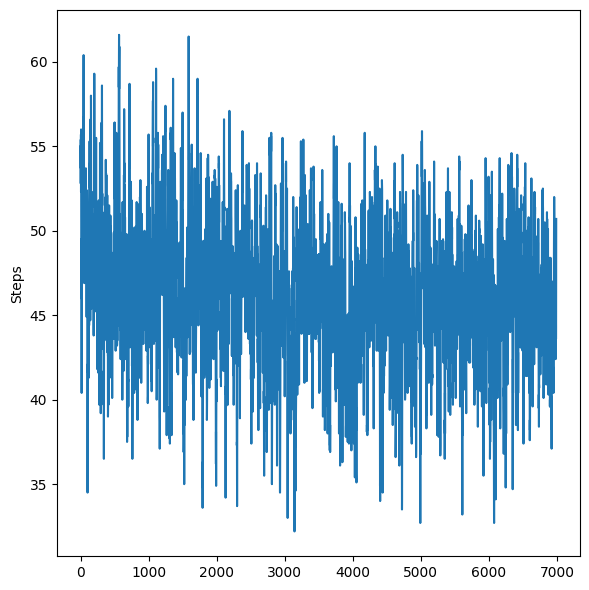

In [57]:

%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
window_size = 10

steps = np.convolve(train_hist["steps"],  np.ones(window_size)/window_size, mode='valid')

# Plot rewards
ax1.plot(steps)
ax1.set_ylabel('Steps')

plt.tight_layout()
plt.show()


/Users/paultoudret/Documents/ENSAE/GIT/RL_project_sailing/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paultoudret/Documents/ENSAE/GIT/RL_project_sailing/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[]

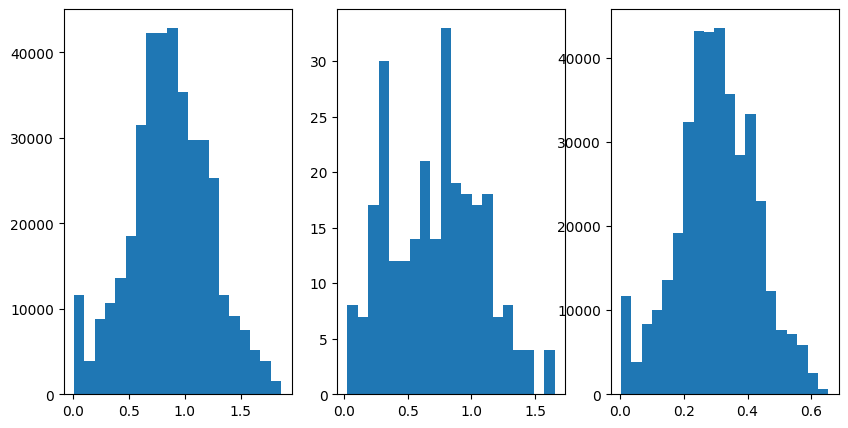

In [58]:
%matplotlib inline
polar_mat = sailor.polar

speeds = []
speed_distrib = []
speed_norm = []
for key in polar_mat.keys():
    wind_b, wind_mag, action = key
    speeds.append(np.mean(polar_mat[key]))
    speed_distrib.extend(polar_mat[key])
    for s in polar_mat[key]:
        speed_norm.append(s / wind_mag*4)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].hist(speed_distrib,bins=20)
axes[1].hist(speeds,bins=20)
axes[2].hist(speed_norm,bins=20)
plt.plot()
    

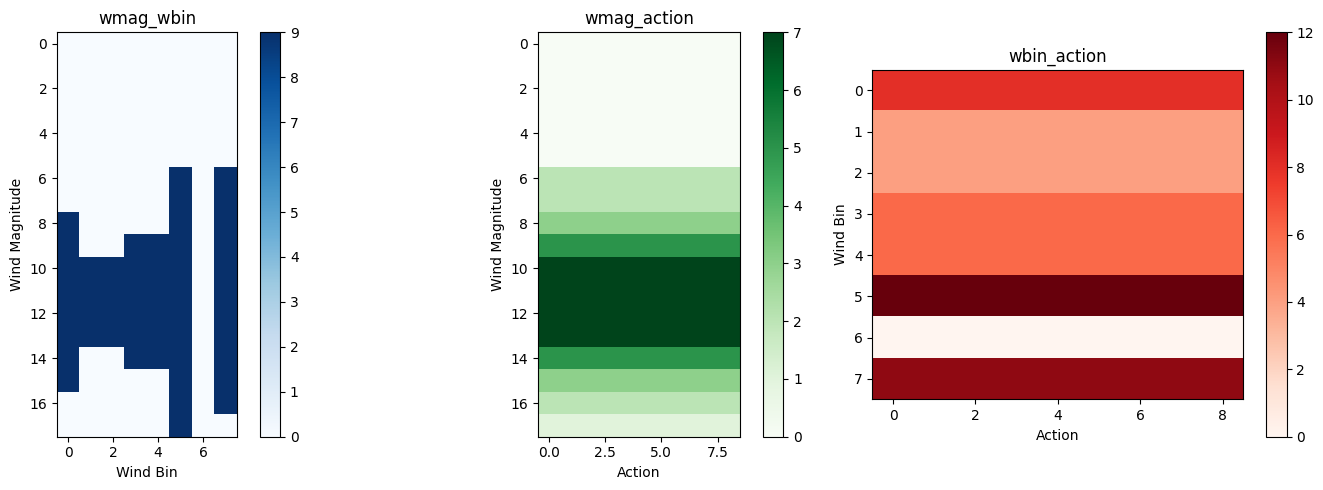

In [59]:
%matplotlib inline
polar_mat = sailor.polar

wmag = []
wbin = []
actions = []


for key in polar_mat.keys():
    wind_b, wind_mag, action = key
    wbin.append(wind_b)
    wmag.append(wind_mag)
    actions.append(action)

wmag_wbin = np.zeros((max(wmag)+1, max(wbin)+1))
wmag_action = np.zeros((max(wmag)+1, max(actions)+1))
wbin_action = np.zeros((max(wbin)+1, max(actions)+1))

for key in polar_mat.keys():
    wind_b, wind_mag, action = key
    wmag_wbin[wind_mag][wind_b] += 1
    wmag_action[wind_mag][action] += 1
    wbin_action[wind_b][action] += 1
    

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Affichage de la matrice wmag_wbin
im0 = axes[0].imshow((wmag_wbin), cmap='Blues')
axes[0].set_title('wmag_wbin')
axes[0].set_xlabel('Wind Bin')
axes[0].set_ylabel('Wind Magnitude')
fig.colorbar(im0, ax=axes[0])

# Affichage de la matrice wmag_action
im1 = axes[1].imshow((wmag_action), cmap='Greens')
axes[1].set_title('wmag_action')
axes[1].set_xlabel('Action')
axes[1].set_ylabel('Wind Magnitude')
fig.colorbar(im1, ax=axes[1])

# Affichage de la matrice wbin_action
im2 = axes[2].imshow((wbin_action), cmap='Reds')
axes[2].set_title('wbin_action')
axes[2].set_xlabel('Action')
axes[2].set_ylabel('Wind Bin')
fig.colorbar(im2, ax=axes[2])

# Affichage de la figure
plt.tight_layout()
plt.show()
    

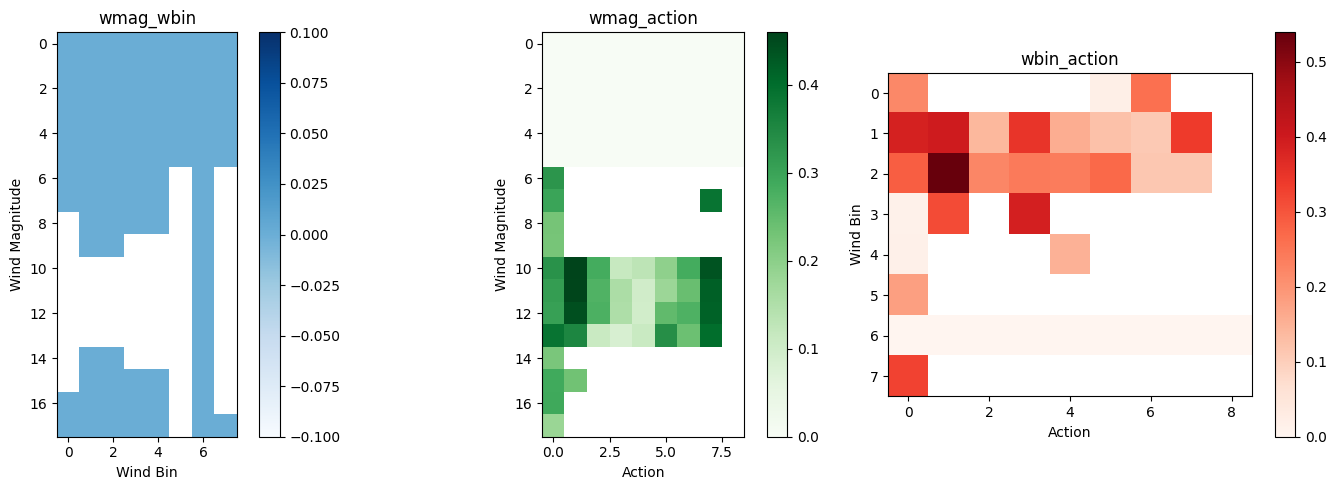

In [60]:
%matplotlib inline
polar_mat = sailor.polar

wmag = []
wbin = []
actions = []

dico = {}

for key in polar_mat.keys():
    wind_b, wind_mag, action = key
    wbin.append(wind_b)
    wmag.append(wind_mag)
    actions.append(action)

    dico.setdefault(key, [])
    dico[key].extend([x / wind_mag * 4 for x in polar_mat[key]])

wmag_wbin = np.zeros((max(wmag)+1, max(wbin)+1))
wmag_action = np.zeros((max(wmag)+1, max(actions)+1))
wbin_action = np.zeros((max(wbin)+1, max(actions)+1))

for key in dico.keys():
    wind_b, wind_mag, action = key
    wmag_wbin[wind_mag][wind_b] = np.mean((dico[key]))
    wmag_action[wind_mag][action] = np.mean((dico[key]))
    wbin_action[wind_b][action] = np.mean((dico[key]))
    

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Affichage de la matrice wmag_wbin
im0 = axes[0].imshow(wmag_wbin, cmap='Blues')
axes[0].set_title('wmag_wbin')
axes[0].set_xlabel('Wind Bin')
axes[0].set_ylabel('Wind Magnitude')
fig.colorbar(im0, ax=axes[0])

# Affichage de la matrice wmag_action
im1 = axes[1].imshow(wmag_action, cmap='Greens')
axes[1].set_title('wmag_action')
axes[1].set_xlabel('Action')
axes[1].set_ylabel('Wind Magnitude')
fig.colorbar(im1, ax=axes[1])

# Affichage de la matrice wbin_action
im2 = axes[2].imshow(wbin_action, cmap='Reds')
axes[2].set_title('wbin_action')
axes[2].set_xlabel('Action')
axes[2].set_ylabel('Wind Bin')
fig.colorbar(im2, ax=axes[2])

# Affichage de la figure
plt.tight_layout()
plt.show()

In [62]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
%matplotlib notebook

test_agent = MyNaiveAgent()
n = np.random.randint(0, 100000)
i = np.random.randint(1,4)
results_steps, results_rew, results_avg_speed = test(sailor, num_test=1, max_steps=500, seed=[n], env=i, verbose=False)
results_steps2, results_rew2, results_avg_speed2 = test(test_agent, num_test=1, max_steps=500, seed=[n], env=i, verbose=False)


coordinates = sailor.hist_pos
x_data = []
y_data = []
actions = sailor.hist_actions

for x, y in coordinates:
    x_data.append(x)
    y_data.append(y)

coordinates2 = test_agent.hist_pos
x_data2 = []
y_data2 = []
actions2 = test_agent.hist_actions

for x, y in coordinates2:
    x_data2.append(x)
    y_data2.append(y)

# Initialisation de la figure et des axes
fig, ax = plt.subplots()
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
line, = ax.plot([], [], 'b-', lw=2)  # 'b-' signifie une ligne bleue
line2, = ax.plot([], [], 'r-', lw=2)
title = ax.set_title("Steps")


# Initialisation de la ligne
def init():
    line.set_data([], [])
    return line,

# Fonction d'animation
def animate(i):
    x = x_data[:i]
    y = y_data[:i]
    line.set_data(x, y)
    x2 = x_data2[:i]
    y2 = y_data2[:i]
    line2.set_data(x2, y2)
    title.set_text(f"Steps - {i} - Action - {actions[i]}")
    return line, line2,

# Création de l'animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(coordinates), interval=100, blit=True)

# Affichage de l'animation dans un notebook Jupyter
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

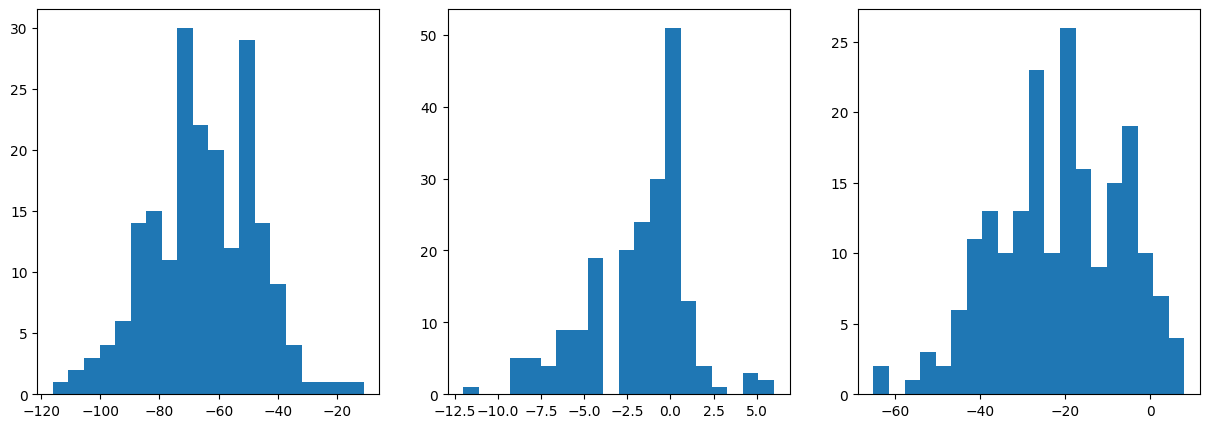

In [63]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

test_agent = MyNaiveAgent()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

num_test = 200
n = [random.randint(0, 200000) for _ in range(num_test)]

for i in range(1,4):
    results_steps, results_rew, results_avg_speed = test(sailor, num_test=num_test, max_steps=500, seed=n, env=i, verbose=False)
    results_steps2, results_rew2, results_avg_speed2 = test(test_agent, num_test=num_test, max_steps=500, seed=n, env=i, verbose=False)

    delta = []
    for s1, s2 in zip(results_steps, results_steps2):
        delta.append(s1 - s2)

    axes[i-1].hist(delta,bins=20)

plt.show()

In [64]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=sailor,
    output_path="agents/capitaine_2.py",
    agent_class_name="Capitaine_2"
)

Agent saved to agents/capitaine_2.py
The file contains 9515 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb
